<a href="https://colab.research.google.com/github/afi1289/BiLSTM-CRF/blob/main/2_BiLSTM_CRF_from_medium.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
# To determine which version you're using:
!pip show tensorflow

# For the current version: 
#!pip install --upgrade tensorflow

Name: tensorflow
Version: 2.4.1
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /usr/local/lib/python3.6/dist-packages
Requires: wrapt, absl-py, astunparse, typing-extensions, tensorboard, keras-preprocessing, protobuf, wheel, gast, tensorflow-estimator, grpcio, opt-einsum, termcolor, numpy, google-pasta, h5py, flatbuffers, six
Required-by: fancyimpute


In [1]:
# to save your time

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
%cd gdrive/My Drive/project_folder/

/content/gdrive/My Drive/project_folder


In [41]:
!ls

'0-Clone GitHub Repository.ipynb'
 1-Baseline_Glove.ipynb
'2- BiLSTM-CRF from medium.ipynb'
'2-Paper Implementation BiLSTM-CRF for Aspect Term Extraction.ipynb'
'3- NER with BERT_Fine-tuning_18_01.ipynb'
 bilstm
 data_movie_absa.json
 glove.42B.300d_rel.pkl
 glove.42B.300d.txt
 glove.840B.300d.txt
 luke_notebook
 model_save
'OLD Notebooks'


In [3]:
!pip install git+https://www.github.com/keras-team/keras-contrib.git

  Cloning https://www.github.com/keras-team/keras-contrib.git to /tmp/pip-req-build-mb38cd4c
  Running command git clone -q https://www.github.com/keras-team/keras-contrib.git /tmp/pip-req-build-mb38cd4c
  Created wheel for keras-contrib: filename=keras_contrib-2.0.8-cp36-none-any.whl size=101066 sha256=0cbef19f33047619b9f01dbdd6f25e565e49802c6f4ebe4e4aeec31a7f2a558b
  Stored in directory: /tmp/pip-ephem-wheel-cache-u0wrjuqx/wheels/11/27/c8/4ed56de7b55f4f61244e2dc6ef3cdbaff2692527a2ce6502ba
Successfully built keras-contrib


In [4]:
import pandas as pd
import numpy as np
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from keras.models import Model, Input
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional
from keras_contrib.layers import CRF
from pathlib import Path
# import utils

In [5]:
glove_path = "/content/gdrive/My Drive/project_folder/glove.840B.300d.txt"

In [6]:
# read glove to embedings_index
from tqdm import tqdm


embeddings_index = {}
with open(glove_path, encoding='utf8') as f:
    for i, line in tqdm(enumerate(f)):
        values = line.split()
        word = ''.join(values[:-300])
        coefs = np.asarray(values[-300:], dtype='float32')
        embeddings_index[word] = coefs
print("Done!")

2196017it [02:50, 12845.34it/s]

Done!


#2. Data Reformation

##2.1. What I should do: 

####1.   Solve the following subtasks with a **different** Deep learning models, or one model with variants in addition to Baseline method:
*   Aspect Term Extraction
*   Sentiment Term Extraction
*   Modifier Term Extraction

> Compare the performance later:
$F_1(Final) = \frac{F_1(Aspects) + F_1(Sentiments) + F_1(Modifiers)}{3}$

> **Conduct error** analysis on the best model (which returns the best $F_1$ score)

> It is better to apply the model for each subtask **sequentially** without co-extraction, but be **aware** with splitting the dataset into **train-test** data.

> It is NOT **NER** task! It is very similar task! You can use a model based on NER to solve these problems because our problem is considered as token classification problem or Information extraction problem.


####2.   The dataset should be splited into 80% or training and 20% for testing using ```cross_validation``` or ```train_test_split```


*   You can aggregate Training dataset
    *    Try various aggregation rules because you have to explain you why you did that
*   DON'T aggregate Test dataset:
    *   **Essential Setting**:The model predictions MUST be compared with labels for ALL users
    *   Alternative Setting: Remove any label associated with UNCERTAINTY (i.e., convert it to **O** label)
*   Later, you will get Final IDs for evaluation, e.g., Test data have specific IDs -> Therefore, try to find a function that extract specific reviews based on their IDs


####3.   In this step the json structure should be changed into two lists structure:


In [7]:
import json
with open('/content/gdrive/My Drive/project_folder/data_movie_absa.json') as infile:
  data = json.load(infile)

*   Two kind of lists should be extracted from the json file 
*   The **first one** contains all sentences (with lower case by using BiLSTM) as follows:

Example for senteces:
```
[['Best', 'show', 'ever', '!'],
 ['Its', 'a', 'great', 'show'],
 ['Season', '2', 'continues', 'the', 'story', 'well', 'while', 'adding', 'not', 'bad', 'new', 'characters', '.']]
```

*  The **second list** should contain only one label of the following: aspects, sentiments, modifiers:

The labels for example sentences:
```
 [['O', 'B_A', 'O', 'O'],
  ['O', 'O', 'B_S', 'O'],
  ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'BM', 'O', 'O']]
```


##2.2. List of sentences
You can get list of lists that contains all tokenized sentences (lower case by using BiLSTM-CRF)

In [8]:
# get keys and values from data, index them, loop over each index and (key,value) pair
sentences = []
for i,(k,v) in enumerate(data.items()):
    tokens = v.get('tokens')                       # from the variable v, get the value of the "tokens" key. -> ['Best', 'show', 'ever', '!']
    tokens = [token.lower() for token in tokens]   # convert each element in the list to lower case! (I think that will not consider the UPPER case words which have a sentimen!)
    sentences.append(tokens)             # append the lowerd case sentence into sentences list

In [9]:
sentences[0:3]

[['best', 'show', 'ever', '!'],
 ['its', 'a', 'great', 'show'],
 ['my', '6', 'year', 'old', 'and', 'i', 'love', 'this', 'show', '!']]

##2.3. Extract aspects, sentiments, modifiers.. :
Define function to extract the values associated with any key in nested JSON file

The [first idea](https://hackersandslackers.com/extract-data-from-complex-json-python/) (doesn't work properley): \


Therefore, someone has edited [here](https://gist.github.com/toddbirchard/b6f86f03f6cf4fc9492ad4349ee7ff8b) (doesn't returns lists, so I changed the few last lines):

In [10]:
# Define function to extract the values associated with any key in nested JSON file
def json_extract(json_ob, key):
    
    arr = []

    def extract(json_ob, arr, key):
       if isinstance(json_ob, dict):
           for k, v in json_ob.items():
               if isinstance(v, (dict, list)):
                   if k == key:
                       arr.append(v)
                   extract(v, arr, key)
               elif k == key:
                   arr.append(v)
       elif isinstance(json_ob, list):
           for item in json_ob:
               extract(item, arr, key)
       return arr

    results = extract(json_ob, arr, key)
    
    return results

In [11]:
# Extract all the values associated with the key "aspects"
asp_users = json_extract(data,"aspects")

# Extract all the values associated with the key "sentiments"
sen_users = json_extract(data,"sentiments")

# Extract all the values associated with the key "modifiers"
mod_users = json_extract(data,"modifiers")

# Extract all the values associated with the key "aspect_uncertainty"
un_asp_users = json_extract(data,"aspects_uncertainty")

# Extract all the values associated with the key "sentiments_uncertainty"
un_sen_users = json_extract(data,"sentiments_uncertainty")

# Extract all the values associated with the key "modifiers_uncertainty"
un_mod_users = json_extract(data,"modifiers_uncertainty")

print("The first sentence: ", sentences[0])
print("Example of aspect labels for the first review: ",(asp_users[:3]))
print("Number of aspect label lists from 3 users: ", len(asp_users))
print("Maximum length of labels list: ", len(max(asp_users)))


The first sentence:  ['best', 'show', 'ever', '!']
Example of aspect labels for the first review:  [['O', 'B_A', 'O', 'O'], ['O', 'B_A', 'O', 'O'], ['O', 'B_A', 'O', 'O']]
Number of aspect label lists from 3 users:  9672
Maximum length of labels list:  165


###2.3.1. Count labels in entire data 

In [12]:
# define function to count labels
def labels_counter(label_lists):
  counter = 0
  for label_list in label_lists:
    for each_label in label_list:
      if each_label != 'O':
        counter += 1
  return counter

print("The number of aspect labels in data:", labels_counter(asp_users))
print("The number of aspect uncertainty labels in data:", labels_counter(un_asp_users))
print(" ")
print("The number of sentiment labels in data:", labels_counter(sen_users))
print("The number of sentiment uncertainty labels in data:", labels_counter(un_sen_users))
print(" ")
print("The number of modifier labels in data:", labels_counter(mod_users))
print("The number of modifier uncertainty labels in data:", labels_counter(un_mod_users))

The number of aspect labels in data: 11871
The number of aspect uncertainty labels in data: 239
 
The number of sentiment labels in data: 17268
The number of sentiment uncertainty labels in data: 614
 
The number of modifier labels in data: 3918
The number of modifier uncertainty labels in data: 49


###2.3.2. Function to collect all user labels:

In [13]:
# define function to consolidate labels from all users 
# update: optimized function with integrated function to gather all possible labels
def consolidate_labels(lab_user):

  def aggregate_test_labels(a,b,c):
     aggregated_list = []
     # iterate over 3 lists
     for x,y,z in zip(a, b, c):
        if x != 'O':
          aggregated_list.append(x)
        elif y != 'O':
          aggregated_list.append(y)
        elif z != 'O':
          aggregated_list.append(z)
        else:
          aggregated_list.append('O')
     return aggregated_list

  result = [aggregate_test_labels(lab_user[i], lab_user[i+1], lab_user[i+2]) for i in range(0,len(lab_user)-2, 3)] # you can use aggregate_test_labels
  return result


In [14]:
# Consolidate aspect labels, sentiment labels, modifier labels
con_asp_lab = consolidate_labels(asp_users)
con_sen_lab = consolidate_labels(sen_users)
con_mod_lab = consolidate_labels(mod_users)


print(" The first 3 sentences: ", sentences[:3])
print("The result of aspects consolidation: \n",con_asp_lab[:3],"\n")
print("The result of sentiments consolidation: \n",con_sen_lab[:3], "\n")
print("The result of modifiers consolidation: \n",con_mod_lab[:3],"\n")

print("Number of consolidated lists: ",len(con_asp_lab), "\n")

print("Number of aspect labels: ", labels_counter(con_asp_lab))
print("Number of sentiment labels: ", labels_counter(con_sen_lab))
print("Number of modifier labels: ", labels_counter(con_mod_lab))
print("All lists are equal?: ", len(con_asp_lab) == len(con_mod_lab) == len(con_sen_lab))

 The first 3 sentences:  [['best', 'show', 'ever', '!'], ['its', 'a', 'great', 'show'], ['my', '6', 'year', 'old', 'and', 'i', 'love', 'this', 'show', '!']]
The result of aspects consolidation: 
 [['O', 'B_A', 'O', 'O'], ['O', 'O', 'O', 'B_A'], ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B_A', 'O']] 

The result of sentiments consolidation: 
 [['B_S', 'O', 'O', 'O'], ['O', 'O', 'B_S', 'O'], ['O', 'O', 'O', 'O', 'O', 'O', 'B_S', 'O', 'O', 'O']] 

The result of modifiers consolidation: 
 [['O', 'O', 'BM', 'O'], ['O', 'O', 'O', 'O'], ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']] 

Number of consolidated lists:  3224 

Number of aspect labels:  7363
Number of sentiment labels:  10291
Number of modifier labels:  2304
All lists are equal?:  True


 Let's compare our results with what we will get if we use the annotations from one user

In [15]:
# define function extract the annotation of one user
def first_user_extractor(all_labels):
  first_labels = []
  for i in range(0,len(all_labels),3):
    first_labels.append(all_labels[i])
  return first_labels

In [16]:
# count labels 
first_asp_user = first_user_extractor(asp_users)
first_sen_user = first_user_extractor(sen_users)
first_mod_user = first_user_extractor(mod_users)

print("Number of aspect labels: ", labels_counter(first_asp_user))
print("Number of sentiment labels: ", labels_counter(first_sen_user))
print("Number of modifier labels: ", labels_counter(first_mod_user))

Number of aspect labels:  4185
Number of sentiment labels:  6776
Number of modifier labels:  1299


The variables :```con_asp_lab```, ```con_sen_lab```, ```con_mod_lab```  will be used to train the model in addition to the variable ```sentences```:


In [17]:
# remember the length of each one
len(con_asp_lab)

3224

##2.4. Our data:

In [18]:
sentences[:4]

[['best', 'show', 'ever', '!'],
 ['its', 'a', 'great', 'show'],
 ['my', '6', 'year', 'old', 'and', 'i', 'love', 'this', 'show', '!'],
 ['season',
  '2',
  'continues',
  'the',
  'story',
  'well',
  'while',
  'adding',
  'great',
  'new',
  'characters',
  '.']]

In [19]:
con_asp_lab[:4]

[['O', 'B_A', 'O', 'O'],
 ['O', 'O', 'O', 'B_A'],
 ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B_A', 'O'],
 ['B_A', 'I_A', 'O', 'O', 'B_A', 'O', 'O', 'O', 'O', 'O', 'B_A', 'O']]

##2.5. Split train-test data

In [20]:
sentences_train = sentences[:2579]
sentences_test = sentences [2597:]
labels_train = con_asp_lab [:2579]
labels_test = con_asp_lab[2579:]

# 3. [BiLSTM-CRF Model](https://towardsdatascience.com/bilstm-crf-for-aspect-term-extraction-87630406573a)

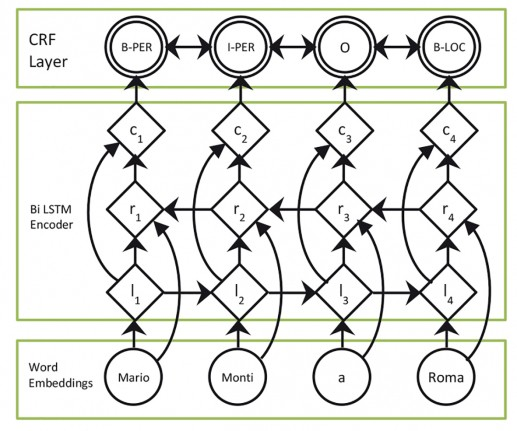

* [Word Embedding](https://www.analyticsvidhya.com/blog/2017/06/word-embeddings-count-word2veec/). This layer will convert each word to a vector with fixed dimensions. Usually there is no needs to train the word vector by yourself. There are already many pre-trained word embedding data for use, and we use GloVe.
* [BiLSTM Encoder](https://datascience.stackexchange.com/questions/25650/what-is-lstm-bilstm-and-when-to-use-them). This encoder contains two LSTM layers and it can learn the information from context.
* [CRF layer](https://createmomo.github.io/2017/09/12/CRF_Layer_on_the_Top_of_BiLSTM_1/). This layer could add some constrains to the final predicted labels to ensure they are valid. These constrains can be learned by the CRF layer automatically from the training dataset during the training process.

In [21]:
# generate vocabulary,token ids and embeddings for vocabulary
# Vocabulary contains all tokens that appear once in the data
# This is important because on the basis of this vocabulary an ID is assigned for each token and corresponding embeddings are assigned for each ID
# tokens themselves are not passed into the neural network, but the Token_ID
words = set(['##unknown_token##','##padding_token##']) # create a set of two elements
for v in data.values():
    words.update(set(v['tokens']))     # To add items from another set (here set from the elements of values associated with the key 'tokens') into the current set (here vocabulary), use the update() method.
words = list(words)               # create a list from the set vocabulary (because Set items are unordered, unchangeable, and do not allow duplicate values)
words.sort()                           # sort the list vocabulary


In [22]:
# check the ration of words in words embedding
word_true = 0

for word in words:
    if word in embeddings_index:
        word_true += 1

In [23]:
print(len(words))
print(word_true)
print("The ration of words in embedding is: ", word_true/len(words))

8784
8347
The ration of words in embedding is:  0.9502504553734062


In [24]:
# create a dictionary of words-index pairs
word2idx = {}
word2idx['<PAD>'] = 0
word2idx['<UNK>'] = 1
for i, word in enumerate(words):
    word2idx[word] = i + 2

In [25]:
word2idx['best']

3384

In [26]:
EMBEDDING_DIM = 300

embedding_matrix = np.zeros((len(words)+2, EMBEDDING_DIM))

for word, i in word2idx.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is None:
        embedding_matrix[i] = embeddings_index['unk']
    else:
        embedding_matrix[i] = embedding_vector

# embedding_matrix[0] is all zeros for padding
embedding_matrix[0] = np.zeros(EMBEDDING_DIM)

In [27]:
embedding_matrix.shape

(8786, 300)

In [28]:
'unk' in embeddings_index

True

In [29]:
len(word2idx)

8786

In [30]:
# define function to merge sentences with labels lists
def sentence_getter(first_list, second_list):
  # zip both lists. You end up with pairs of lists
  pl = zip(first_list, second_list)

  # zip each pair of list and make list of tuples out of each pair of lists.
  result = [[(e[0], e[1]) for e in zip(l[0], l[1])] for l in pl]
  return result


In [31]:
sentences_t = sentence_getter(sentences_train, labels_train)

In [32]:
sentences_t[0]

[('best', 'O'), ('show', 'B_A'), ('ever', 'O'), ('!', 'O')]

In [33]:
max_len = 75
n_words = len(word2idx)

tags = set()                   # we want to define all label classes as set then convert it to a list: ['B_A', 'I_A', 'O']
for row in labels_train:
    tags.update(row)
tags = list(tags)
tags.sort()

n_tags = len(tags)
tag2idx = {t: i + 1 for i, t in enumerate(tags)}
tag2idx['<pad>'] = 0
n_tags = len(tag2idx) # Due to <pad>, here total tag number is from 17 to 18

In [34]:
print(tags)
print(tag2idx)

['B_A', 'I_A', 'O']
{'B_A': 1, 'I_A': 2, 'O': 3, '<pad>': 0}


In [35]:
# Word2inx & Padding for X
X = [[word2idx.get(w[0], 1) for w in s] for s in sentences_t]
X_train = pad_sequences(maxlen=max_len, sequences=X, padding="post", value=0)

# Word2inx & Padding for y
y = [[tag2idx[w[1]] for w in s] for s in sentences_t]
y = pad_sequences(maxlen=max_len, sequences=y, padding="post", value=0)

# Get one-hot labels
y_train = [to_categorical(i, num_classes=n_tags) for i in y]

In [36]:
print(X[0])

[3384, 7574, 4688, 2]


In [37]:
print(len(X_train))
print(len(y_train))

2579
2579


In [38]:
n_words

8786

In [39]:
#==============Bi-LSTM CRF=============
input = Input(shape=(max_len,))
model = Embedding(input_dim=n_words, 
                  output_dim=300,
                  weights=[embedding_matrix],
                  input_length=max_len, 
                  mask_zero=True)(input)  # 20-dim embedding
model = Bidirectional(LSTM(units=256, return_sequences=True,
                           recurrent_dropout=0.1))(model)  # variational biLSTM
model = TimeDistributed(Dense(50, activation="tanh"))(model)  # a dense layer as suggested by neuralNer
crf = CRF(n_tags)  # CRF layer
out = crf(model)  # output

model = Model(input, out)
model.compile(optimizer="rmsprop", loss=crf.loss_function, metrics=[crf.accuracy])
model.summary()

AttributeError: ignored

In [ ]:
history = model.fit(X_train, np.array(y_train), batch_size=32, epochs=8,
                    validation_split=0.1, verbose=1)

In [ ]:
hist = pd.DataFrame(history.history)


In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use("ggplot")
plt.figure(figsize=(12,12))
plt.plot(hist["loss"])
plt.plot(hist["val_loss"])
plt.show()

### Predict on Test dataset

In [ ]:
data = data_test

# Sentence class
class SentenceGetter(object):

    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, t) for w, t in zip(s["Word"].values.tolist(),
#                                                            s["POS"].values.tolist(),
                                                           s["Tag"].values.tolist())]
        self.grouped = self.data.groupby("Sentence #").apply(agg_func)
        self.sentences = [s for s in self.grouped]

    def get_next(self):
        try:
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None

getter = SentenceGetter(data)
sentences = getter.sentences # get all sentences
   
# Word2inx & Padding for X
X = [[word2idx.get(w[0], 1) for w in s] for s in sentences]
X_test = pad_sequences(maxlen=max_len, sequences=X, padding="post", value=0)

# Word2inx & Padding for y
y = [[tag2idx[w[1]] for w in s] for s in sentences]
y = pad_sequences(maxlen=max_len, sequences=y, padding="post", value=0)

# Get one-hot labels
y_test = [to_categorical(i, num_classes=n_tags) for i in y]

In [ ]:
print(sentences[1])
print(X_test[1])
print(np.argmax(y_test[1], -1))

In [ ]:
# Predictions.
idx2word = {value: key for key, value in word2idx.items()}
idx2tag = {value: key for key, value in tag2idx.items()}


true_all = np.argmax(y_test, -1)

true_all_tags = [[idx2tag[idx] for idx in s if idx!=0] for s in true_all]

p_all = model.predict(np.array(X_test)) # (4796, 75, 18)
p_all= np.argmax(p_all, axis=-1) # (4796, 75)
p_all_tags = [[idx2tag[idx] for idx in s] for s in p_all] # ['B-gpe', 'O', 'O', 'O']

for i, true in enumerate(true_all_tags):
    length = len(true)
    p_all_tags[i] = p_all_tags[i][:length]

p_all_tags = [[x.replace('<pad>', 'O') for x in s] for s in p_all_tags]

# for (true_tag, p)

print(sentences[3])
print(X_test[3])
print(true_all_tags[3])
print(p_all_tags[3])

In [ ]:
print("{:15}||{:5}||{}".format("Word", "True", "Pred"))
print(30 * "=")
for w, t, pred in zip(sentences[3], true_all_tags[3], p_all_tags[3]):
    if w != 0:
        print("{:15}: {:5} {}".format(w[0], w[1], pred))

In [ ]:
# Evaluation
from seqeval.metrics import f1_score, classification_report
print(f1_score(true_all_tags, p_all_tags))
print(classification_report(true_all_tags, p_all_tags))